# Importing libraries, loading and transforming data

In [16]:
%pip install -q evaluate transformers==4.28.1
%pip install -U -q datasets
%pip install -q torchaudio==0.12
%add-apt-repository -y ppa:savoury1/ffmpeg4 
%apt-get -qq install -y ffmpeg
%pip install -q mlflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%add-apt-repository` not found.


In [66]:
#imports
import pandas as pd
import gc
import re
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas()
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import torch
import datasets
import transformers
print(transformers.__version__)

4.28.1


In [67]:
df_list = []
for loc in ['Train', 'Test']:
    df_tmp = pd.read_csv(f"archive\Metadata_{loc}.csv")
    df_list.append(df_tmp)
df = pd.concat(df_list, axis=0)
df['Class'] = df['Class'].replace({"Sound_Guiatr": "Sound_Guitar"})
# remove violin label as it is contaminated by Drums
df = df[df['Class']!="Sound_Violin"]
print(df.shape)
df.sample(5).T

(1989, 2)


,2239,2384,913,9,837
FileName,ROOM_room1_MUS_swing_DEV_ipad.wav,ROOM_room4_MUS_mozart_DEV_ipad.wav,RealDrum01_00HHtrain.wav,intro-music-black-box-simple-guitar-12701.wav,DRUM_SOUND (65).wav
Class,Sound_Piano,Sound_Piano,Sound_Drum,Sound_Guitar,Sound_Drum


In [68]:
df['Class'].value_counts()

Class
Sound_Guitar    720
Sound_Drum      720
Sound_Piano     549
Name: count, dtype: int64

In [69]:
RATE_HZ = 16000 # resampling rate in Hz
MAX_LENGTH = 240000 # maximum audio interval length to consider (= RATE_HZ * SECONDS)
labels = ['Sound_Guitar', 'Sound_Drum', 'Sound_Piano']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'Sound_Guitar', 1: 'Sound_Drum', 2: 'Sound_Piano'} 

 {'Sound_Guitar': 0, 'Sound_Drum': 1, 'Sound_Piano': 2}


In [70]:
from pathlib import Path
import torchaudio

def load_data():
    file_list = []
    sample_list = []
    for file in Path('archive/').glob('*_submission\*_submission\*.wav'):
        sample_name = file.stem + '.wav' #re.match(r"(\d+)", file.stem).group(0)
        file_list.append(file)
        sample_list.append(str(sample_name))
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['FileName'] = sample_list
    return dd

In [71]:
dd = load_data()
dd = dd.set_index('FileName').join(df.set_index('FileName'), how='inner')
dd = dd[dd['Class'].isin(labels)]
dd['label'] = dd['Class'].apply(lambda x: label2id[x])
selected_cols = ['file', 'label', 'Class']
dd = dd[selected_cols]
dd.sample(5).T

FileName,ska_2_150BPM.wav,RealDrum01_12SDtrain.wav,ROOM_room6_MUS_beethoven2_DEV_iphone.wav,intro-music-black-box-simple-guitar-12701.wav,WaveDrum02_45SD (44).wav
file,archive\Test_submission\Test_submission\ska_2_...,archive\Train_submission\Train_submission\Real...,archive\Train_submission\Train_submission\ROOM...,archive\Test_submission\Test_submission\intro-...,archive\Train_submission\Train_submission\Wave...
label,0,1,2,0,1
Class,Sound_Guitar,Sound_Drum,Sound_Piano,Sound_Guitar,Sound_Drum


In [72]:
dd = dd.reset_index(drop=True)
dd.head()

,file,label,Class
0,archive\Train_submission\Train_submission\0295...,2,Sound_Piano
1,archive\Train_submission\Train_submission\0355...,2,Sound_Piano
2,archive\Train_submission\Train_submission\04-4...,1,Sound_Drum
3,archive\Train_submission\Train_submission\0465...,1,Sound_Drum
4,archive\Train_submission\Train_submission\0543...,1,Sound_Drum


In [73]:
def get_transform_audio(file):
    audio,rate = torchaudio.load(str(file))
    transform = torchaudio.transforms.Resample(rate,RATE_HZ)
    audio = transform(audio).squeeze(0).numpy()
    audio = audio[:MAX_LENGTH] # truncate to first part of audio to save RAM
    # return audio only if it is full length audio
    if audio.shape[0]==MAX_LENGTH:
        return audio
dd['audio'] = dd['file'].progress_apply(get_transform_audio)

  0%|          | 0/1989 [00:00<?, ?it/s]

100%|██████████| 1989/1989 [00:39<00:00, 49.73it/s]


In [74]:
dd = dd.dropna(subset=['audio'])
dd.shape

(848, 4)

In [75]:
%%time
# random oversampling of all minority classes
y = dd[['label']]
dd = dd.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
dd, y_resampled = ros.fit_resample(dd, y)
del y
dd['label'] = y_resampled
del y_resampled
gc.collect()

CPU times: total: 938 ms
Wall time: 2.12 s


15299

In [76]:
dd.shape, dd['label'].value_counts()

((1095, 4),
 label
 0    365
 1    365
 2    365
 Name: count, dtype: int64)

In [77]:
%%time
dd = dd.drop(['file'], axis=1)

CPU times: total: 0 ns
Wall time: 1 ms


In [78]:
dd.sample(5).T

,866,244,123,906,258
Class,Sound_Guitar,Sound_Piano,Sound_Piano,Sound_Guitar,Sound_Piano
audio,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
label,0,2,2,0,2


In [79]:
from datasets import Dataset
dd = Dataset.from_pandas(dd)

In [80]:
from collections import Counter
Counter(dd['label']).items()

dict_items([(0, 365), (1, 365), (2, 365)])

In [81]:
#dd = dd.train_test_split(test_size=0.2)
dd

Dataset({
    features: ['Class', 'audio', 'label'],
    num_rows: 1095
})

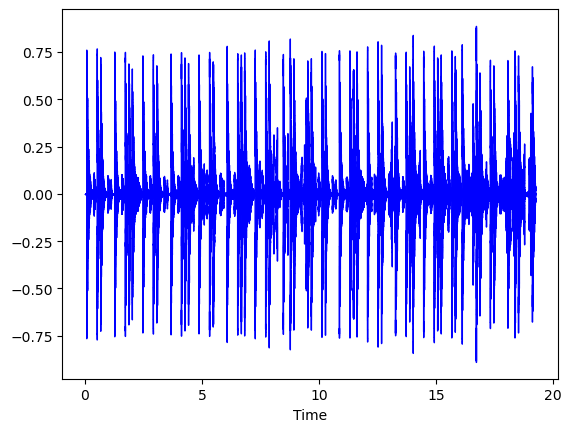

In [82]:
import librosa
import librosa.display
y,sr=librosa.load('archive/Test_submission/Test_submission/100bpm-808-like-drum-loop-74838.wav') #load the file
librosa.display.waveshow(y,sr=sr, x_axis='time', color='blue')

In [84]:
def waveform_from_data():
    waveform_list = []
    for file in Path('archive/').glob('*_submission\*_submission\*.wav'):
        waveform_list.append(librosa.load(f'{file}'))
    d_test = pd.DataFrame()
    d_test['waveform'] = waveform_list
    return waveform_list


dd['waveform'] = waveform_from_data()



TypeError: 'Dataset' object does not support item assignment

In [ ]:
dd.sample(5).T
dd['waveform'][0]
librosa.display.waveshow(dd['waveform'][4][0],sr=sr, x_axis='time', color='blue')

AttributeError: 'DatasetDict' object has no attribute 'sample'

In [54]:
from torch import nn
import torch.nn.functional as F
class FirstCnn(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=0)
        
        # Calculate the output size after two convolutional layers
        self.conv_output_size = self.calculate_conv_output_size()
        
        self.fc1 = nn.Linear(self.conv_output_size, 1)  # Output size is 1 for binary classification (dog or not)
        
    def calculate_conv_output_size(self):
        # Define a dummy input tensor to calculate the output size after convolutions
        dummy_input = torch.zeros(1, 3, self.img_size, self.img_size)
        dummy_output = self.forward_conv(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def forward_conv(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

    def forward(self, x):
        x = self.forward_conv(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
        x = torch.sigmoid(self.fc1(x))  # Sigmoid activation for binary classification
        return x.squeeze()

In [55]:
def training_loop_1(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch_1(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate_1(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch_1(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())
        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate_1(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate_1(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)


def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.long())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())
        hard_preds = output_to_label(z)
        hard_preds = hard_preds.argmax(dim=1)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.long())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            hard_preds = hard_preds.argmax(dim=1)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

In [62]:
print(d_test)
print(dd.shape())

                                               waveform
0     ([-1.142182e-12, -8.1326124e-13, -1.8015999e-1...
1     ([-1.1937118e-12, -1.5916157e-12, -2.2737368e-...
2     ([-3.1832315e-12, -2.3646862e-11, 7.275958e-12...
3     ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4     ([-3.0304978e-10, -5.525606e-10, 2.673533e-10,...
...                                                 ...
2703  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2704  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2705  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2706  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2707  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

[2708 rows x 1 columns]


TypeError: 'dict' object is not callable

In [57]:
from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_dataloader = DataLoader(DogsCatsData(small_train_path, transform), batch_size=64, shuffle=True)
valid_dataloader = DataLoader(DogsCatsData(small_val_path, transform), batch_size=64, shuffle=True)

SyntaxError: invalid syntax (2002000152.py, line 1)

In [56]:
from torch import optim
loss_fn = nn.CrossEntropyLoss()
first_model = FirstCnn(32)
optimizer = optim.Adam(first_model.parameters(), lr = 0.005)
first_model_32, train_losses_32, train_accs_32, val_losses_32, val_accs_32 = training_loop_1(first_model, optimizer, loss_fn, train_dataloader, valid_dataloader,10,1)

NameError: name 'train_dataloader' is not defined

# Load facebook/wav2vec2-base-960h model

In [63]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

model_str = "facebook/wav2vec2-base-960h" 
feature_extractor = AutoFeatureExtractor.from_pretrained(model_str)
model = AutoModelForAudioClassification.from_pretrained(model_str,num_labels=len(labels))
model.config.id2label = id2label
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.weight', 'projector.weight', 'classifier.bias', 'projector.bias', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be 

94.569347


In [64]:
def preprocess_function(batch):    
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)
    inputs['input_values'] = inputs['input_values'][0]
    return inputs

dd['test'] = dd['test'].map(preprocess_function, remove_columns="audio", batched=False)
dd['train'] = dd['train'].map(preprocess_function, remove_columns="audio", batched=False)

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

Map:   0%|          | 0/876 [00:00<?, ? examples/s]

In [65]:
gc.collect()

40

# Train and evaluate model

In [66]:
import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.metrics import roc_auc_score
def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr') # one-vs-rest ROC AUC score
    
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }

In [67]:
from transformers import TrainingArguments, Trainer
batch_size=1
warmup_steps=50
weight_decay=0.02
num_train_epochs=2
model_name = "musical_instrument_detection"
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=5e-6, # 1e-6
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    gradient_accumulation_steps=4, 
    gradient_checkpointing=True,
    eval_steps=1,
    save_strategy='epoch',
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dd["train"],
    eval_dataset=dd["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

In [68]:
trainer.evaluate()

{'eval_loss': 1.0954021215438843,
 'eval_roc_auc': 0.6887691219926269,
 'eval_accuracy': 0.5068493150684932,
 'eval_runtime': 52.2096,
 'eval_samples_per_second': 4.195,
 'eval_steps_per_second': 4.195}

In [69]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Accuracy
1,0.660900,0.720802,0.974822,0.890411
2,0.539600,0.541352,0.991266,0.972603


TrainOutput(global_step=438, training_loss=0.8082633539013666, metrics={'train_runtime': 781.2097, 'train_samples_per_second': 2.243, 'train_steps_per_second': 0.561, 'total_flos': 2.3858711415936e+17, 'train_loss': 0.8082633539013666, 'epoch': 2.0})

In [70]:
trainer.evaluate()

{'eval_loss': 0.5413519740104675,
 'eval_roc_auc': 0.9912656015068381,
 'eval_accuracy': 0.9726027397260274,
 'eval_runtime': 51.9192,
 'eval_samples_per_second': 4.218,
 'eval_steps_per_second': 4.218,
 'epoch': 2.0}

In [71]:
trainer.save_model()

In [72]:
from transformers import pipeline

pipe=pipeline('audio-classification',model=model_name,device=0)

In [73]:
# Drum example
audio,rate=torchaudio.load('/kaggle/input/musical-instruments-sound-dataset/Train_submission/Train_submission/DRUM_SOUND (48).wav')
transform=torchaudio.transforms.Resample(rate,RATE_HZ)
audio=transform(audio).numpy().reshape(-1)[:MAX_LENGTH]
# make a classification pipeline
pipe(audio)

[{'score': 0.575096070766449, 'label': 'Sound_Drum'},
 {'score': 0.26602068543434143, 'label': 'Sound_Guitar'},
 {'score': 0.15888333320617676, 'label': 'Sound_Piano'}]

In [91]:
# Guitar example
audio,rate=torchaudio.load('/kaggle/input/musical-instruments-sound-dataset/Test_submission/Test_submission/rock_6_100BPM.wav')
transform=torchaudio.transforms.Resample(rate,RATE_HZ)
audio=transform(audio).numpy().reshape(-1)[:MAX_LENGTH]
print(audio.shape)
# make a classification pipeline
pipe(audio)

(240000,)


[{'score': 0.5465238094329834, 'label': 'Sound_Guitar'},
 {'score': 0.28378579020500183, 'label': 'Sound_Drum'},
 {'score': 0.16969041526317596, 'label': 'Sound_Piano'}]

In [92]:
from IPython.display import Audio
Audio(audio,rate=RATE_HZ)

# Send model to Huggingface

In [93]:
# finally, save the model to Huggingface
from huggingface_hub import notebook_login
notebook_login()

In [94]:
from huggingface_hub import HfApi
api = HfApi()
repo_id = f"dima806/{model_name}"
try:
    api.create_repo(repo_id)
except:
    print(f"Repo {repo_id} already exists")

In [95]:
api.upload_folder(
    folder_path=model_name,
    path_in_repo = ".",
    repo_id=repo_id,
    repo_type="model"
)

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/757M [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.57k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/623 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/3.57k [00:00<?, ?B/s]

'https://huggingface.co/dima806/musical_instrument_detection/tree/main/.'